### Laboratorio 6 - Generative Adversarial Network
Stefano Aragoni, Carol Arévalo

-----------

En esta práctica se diseñó una Generative Adversarial Network (GAN) con el propósito de poder generar imágenes artificiales que imiten la distribución de los datos originales Para esto, fue necesario diseñar una red neuronal que fuera capaz de generar imágenes, y otra red neuronal que fuera capaz de diferenciar entre imágenes reales y generadas. 

A continuación se muestra el código utilizado para la creación de la GAN, así como los resultados obtenidos.

------- 

##### Importar librerías

Como primer paso, se importaron las librerías necesarias para la creación de la GAN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
import tensorflow as tf
from keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import os
import cv2
from tqdm import tqdm 
import pickle
from keras.preprocessing.image import ImageDataGenerator
import sys
from PIL import Image
import glob

--------
### **Preparación de Datos**

##### Cargar el dataset de CelebA y Preprocesamiento de Datos 

Para iniciar, se descargó el dataset de CelebA. Este conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u. A continuación se muestra la ubicación de las imágenes en el dataset.

In [2]:
# Direcciones de los archivos
image_ids = glob.glob('archive/img_align_celeba/img_align_celeba/*')

# Cantidad de fotos en el directorio
n_fotos = len(os.listdir("archive/img_align_celeba/img_align_celeba"))
print(n_fotos, "fotos en el directorio")

202599 fotos en el directorio


A través de la librería de PIL, se cargaron las imágenes en un arreglo de numpy.

Asimismo, se les aplicó un preprocesamiento, el cual consistió en normalizar los valores de los pixeles de las imágenes, recortarlas y redimensionarlas a 64 X 64.

In [3]:
crop = (30, 55, 150, 175)
images = []

# Cargo las imagenes
for i, image_id in tqdm(enumerate(image_ids)):
    if i >= 50000:
        break
    
    # Cargo la imagen 
    img = Image.open(image_id)
    img = img.crop(crop).resize((64, 64))       # PRE-PROCESAMIENTO: Cortar la imagen y redimensionarla

    # Normalizar los valores
    img = np.array(img)
    img = (img - img.min())/(255 - img.min())   # PRE-PROCESAMIENTO: Normalizar los valores entre -1 y 1
    img = img*2-1
    
    # La convierto a un array
    images.append(img)

X_train = np.array(images)
del images

0it [00:00, ?it/s]

50000it [01:40, 500.00it/s]


(50000, 64, 64, 3)


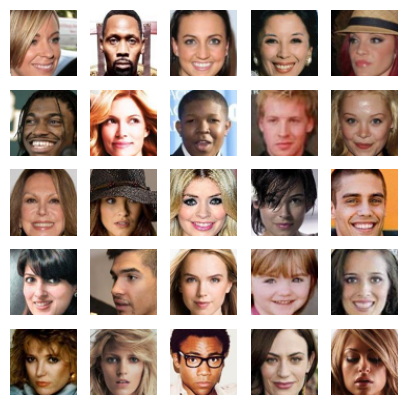

In [7]:
# Mostrar 25 imagenes de entrenamiento
print(X_train.shape)
fig, axs = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        img = X_train[i * 5 + j]
        
        # Mostrar imagen con pixel entre -1 y 1
        axs[i, j].imshow((img + 1)/2)
        axs[i, j].axis('off')

plt.show()

--------
### **Implementación de la GAN**

##### Diseño del generador y el discriminador

A continuación se demuestra el modelo del <font color=orange>generador</font>. En este caso, se utilizó una red neuronal, la cual utiliza relu y tanh como funciones de activación. Se encargará de generar imágenes a partir de un vector de ruido.

In [28]:
tamanio_codificacion = 100

In [42]:
# Generador
generador = Sequential()
generador.add(Dense(8 * 8 * 256, input_shape=[tamanio_codificacion])) 
generador.add(Reshape([8, 8, 256]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same"))
generador.add(BatchNormalization())
generador.add(LeakyReLU(0.2))
generador.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same"))
generador.add(BatchNormalization())
generador.add(LeakyReLU(0.2))
generador.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")) 


A continuación se demuestra el modelo del <font color=orange>discriminador</font>. El discriminador es una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Esta se encarga de diferenciar entre imágenes reales y generadas.

In [43]:
# Discriminador
discriminador = Sequential()
discriminador.add(Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=(64, 64, 3)))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Conv2D(256, kernel_size=5, strides=2, padding="same"))
discriminador.add(LeakyReLU(0.2))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation="sigmoid"))

##### Definición de funciones de pérdida y optimizadores

Con los modelos listos, se procedió a definir las funciones de pérdida y los optimizadores. Esto con el propósito de poder entrenar la GAN. Más específicamente, se utilizó la función de <font color=orange>Binary Cross Entropy</font> (BCE) como función de pérdida, y el <font color=orange>optimizador Adam</font>. 

Asimismo, se indicó que el discriminador no se entrenaría durante el entrenamiento de la GAN, ya que el objetivo es entrenar al generador para que engañe al discriminador.

In [44]:
# Compilar Discriminador
discriminador.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
z = Input(shape=(tamanio_codificacion,))
img = generador(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminador.trainable = False

# Discriminador para evaluar el generador
validity = discriminador(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.002, 0.5))

--------
### **Entrenamiento de la GAN**

##### Implementación del bucle de entrenamiento

La siguiente sección de código se encarga de entrenar la GAN. Para esto, se implementó un bucle de entrenamiento, el cual se encarga de entrenar al generador y al discriminador.

Este codigo se puede ejecutar varias veces para mejorar el entrenamiento de la GAN. En este caso, se ejecutó 3 veces (1,000 épocas cada una) para entrenar el modelo un total de 3,000 épocas.

In [51]:
# Entrenamiento
epochs = 700
batch_size = 128
half_batch = batch_size // 2

for epoch in (range(epochs)):
    
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, tamanio_codificacion))
    gen_imgs = generador.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminador.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminador.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, tamanio_codificacion))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

2/2 [==============================] - 0s 88ms/step
0/700 [D loss: 0.6674915254116058 | D accuracy: 56.25] [G loss: 0.7754481434822083]
2/2 [==============================] - 0s 61ms/step
1/700 [D loss: 0.680544912815094 | D accuracy: 53.90625] [G loss: 0.7684805989265442]
2/2 [==============================] - 0s 64ms/step
2/700 [D loss: 0.6832204461097717 | D accuracy: 58.59375] [G loss: 0.7605350017547607]
2/2 [==============================] - 0s 68ms/step
3/700 [D loss: 0.6816267967224121 | D accuracy: 51.5625] [G loss: 0.7836936712265015]
2/2 [==============================] - 0s 78ms/step
4/700 [D loss: 0.686168372631073 | D accuracy: 56.25] [G loss: 0.7949560880661011]
2/2 [==============================] - 0s 72ms/step
5/700 [D loss: 0.6797194480895996 | D accuracy: 52.34375] [G loss: 0.7960827350616455]
2/2 [==============================] - 0s 89ms/step
6/700 [D loss: 0.6797615587711334 | D accuracy: 53.90625] [G loss: 0.7872470021247864]
2/2 [==============================]

##### Visualización de los resultados

Después de 1,000 épocas, se obtuvieron los siguientes resultados:

1/1 [==============================] - 0s 100ms/step


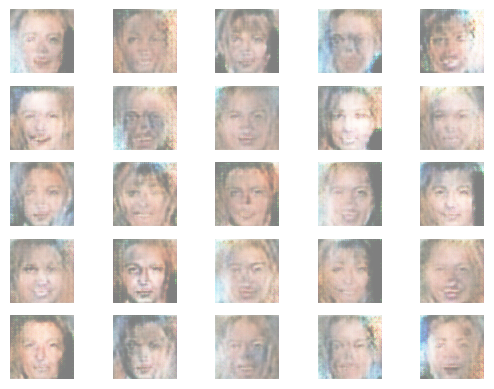

In [48]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        img = gen_imgs[i * 5 + j]

        #  Mostrar imagen con pixel entre -1 y 1
        axs[i, j].imshow((img + 1)/2)
        axs[i, j].axis('off')
plt.show()

Después de 2,000 épocas, se obtuvieron los siguientes resultados:

1/1 [==============================] - 0s 173ms/step


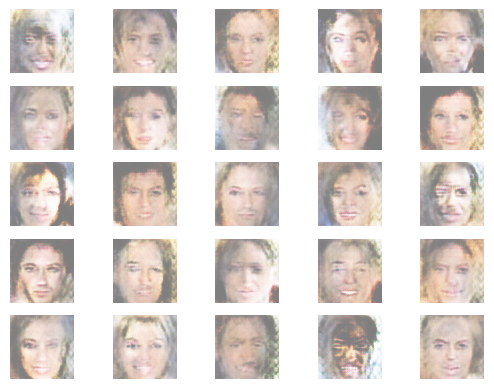

In [50]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        img = gen_imgs[i * 5 + j]

        #  Mostrar imagen con pixel entre -1 y 1
        axs[i, j].imshow((img + 1)/2)
        axs[i, j].axis('off')
plt.show()

Después de 3,000 épocas, se obtuvieron los siguientes resultados:

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?

En este laboratorio, se usó diferentes técnicas, redes neuronales, y herramientas conocidas para poder crear un GAN (Generative Adversarial Network). Sin embargo, durante la elaboración del mismo encontramos ciertos aspectos de la teoría que fueron confusos o desafiantes. 

Por ejemplo, en clase aprendimos que el generador (durante su entrenamiento) nunca llega a ver las imágenes reales. Sin embargo, a la hora de realizar el código fue un poco confuso y desafiante terminar de comprender cómo el generador aprendía si nunca miraba las imágenes. Esto principalmente debido a que cuando aprendimos sobre CNNs, siempre le pasábamos las imágenes reales para que pudiera detectar los patrones presentes. En este caso, para terminar de comprender tuvimos que revisar los ejemplos colocados en Canvas para observar cómo se realiza el proceso de entrenamiento y confirmar que si se pueden obtener buenos resultados con este método. 

Otro aspecto desafiante de la teoría era el colapso de modo. Como se aprendió en clase, las GAN tienen una desventaja de que el generador produce unas pocas imágenes con las cuales puede “tontear” al discriminador. Esto causa que el generador solo produzca imágenes similares a esta. En clase se indicó que utilizar Deep Convolutional GANs puede resolver dicho problema. Sin embargo, nosotros implementamos este tipo de red neuronal y creemos que no terminó de solucionar el problema. Como resultado, sí encontramos este aspecto un poco confuso y frustrante. Esto especialmente considerando el tiempo que se tardaba el modelo para entrenar (más de 2 horas, ya que se usó todas las imágenes).

2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?

Como se mencionó anteriormente, el proceso de entrenamiento de las GAN es completamente diferente a como hemos entrenado redes neuronales en el pasado. Este laboratorio nos ayudó a terminar de comprender la teoría y porque se entrena el modelo por pasos; primero el discriminador y luego el generador. Asimismo, nos obligó a revisar ejemplos y más recursos para poder crear un modelo propio capaz de generar nuevos rostros.

3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?

4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?


5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la  experiencia práctica?